# Classification experiments with `CountVectorizer` / `TfidfVectorizer` (few cases) / Native `CatBoost` text embeddings / `fasttext` + `GradientBoostingClassifier` / `CatBoostClassifier` / `LGBMClassifier`
### Description
Notebook provides research on Gradient boosting implementations for classification task. Numerous vectorizers were used: from CountVectorizer to FastText. GPU experiments were conducted.

### Contents:
* imports & dataset initialization
* GradientBoostingClassifier (2 experiments)
* CatBoost exploration
    * CountVectorizer for vectorization (3 experiments)
    * Text features (2 experiments) - GPU included
* LightGBM exploration
    * CountVectorizer for vectorization (5 experiments) - GPU included
    * fasttext model for vectorization (1 experiment)

**Dataset:** Complete dataset

**Dataset shape:** $(90646, 2)$

**Reviews preprocessing:** depends on experiment

In [1]:
%cd ../..

/home/pristalovya/Документы/nlp-coursework


In [2]:
# from datasets.getters import  load_reviews_Review_Label_clean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer, WhitespaceTokenizer
import nltk
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
from catboost import Pool, CatBoostClassifier
import lightgbm
import catboost
import fasttext

import shap
shap.initjs()

from pprint import pprint

from pymystem3 import Mystem

np.set_printoptions(threshold=np.inf)

data.shape=(90646, 2)
POSITIVE    69219
NEUTRAL     11579
NEGATIVE     9848
Name: label, dtype: int64


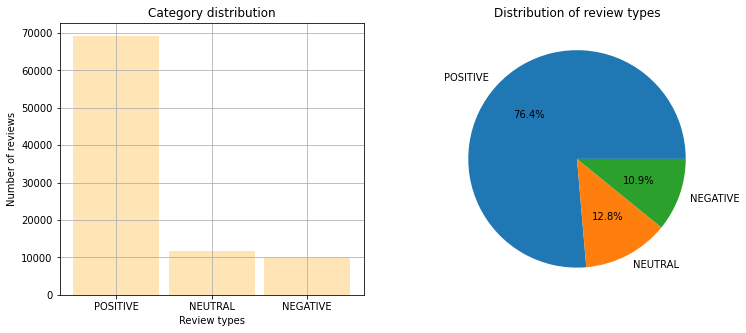

(55346, 2) (23721, 2)


,review,label
54700,фильм стоить выходить предел великобритания . ...,0
67873,это самый впечатляющий по-настоящему жуткий фи...,2
44030,первый часть ' чужой ' свой время произвести в...,2
21503,история начинающий барабанщик эндрю зародиться...,2
75163,< b > дождаться . прокат выйти новый кинолента...,2
...,...,...
6265,"весь равный мера свойственно злорадствовать , ...",0
54886,"неординарный фильм . , уверить — книга всё чёт...",2
76820,"сильно заинтересованный ' дэдпул ' , однако уз...",2
860,"фильм , который неизменно занимать первый мест...",2


In [3]:
# Open dataset
with open('reviews_Review_Label_razdel_nltk.df', 'rb') as f:
    data = dill.load(f)
print(f'{data.shape=}')
print(data.label.value_counts())

# Basic visual
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].bar(data.label.value_counts().index, 
       data.label.value_counts().values, 
       color = 'moccasin', width = 0.9)
ax[0].set_title("Category distribution")
ax[0].set_xlabel("Review types")
ax[0].set_ylabel("Number of reviews")
ax[0].grid(True)

ax[1].pie(data.label.value_counts(), labels=data.label.value_counts().index, autopct='%1.1f%%')
ax[1].set_title('Distribution of review types')

plt.show()

# Basic preprocessing
label_encoding = {
    'POSITIVE': 2,
    'NEUTRAL': 1,
    'NEGATIVE': 0
}

data.label = data.label.apply(lambda label: label_encoding[label])
data = data[data.label != 1].reset_index().drop(columns=['index'])
train, test = train_test_split(data, test_size=0.3, random_state=42)

print(train.shape, test.shape)
train

---

# `GradientBoostingClassifier` experiments (2). Poor results

### Experiment

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Model:** `GradientBoostingClassifier`

**Vectorizer:** `CountVectorizer`, `TfidfVectorizer`

**Comments:** No balancing for dataset

In [6]:
for _tokenizer in ['razdel']:    
    i_to_sw_name = {0: 'nltk', 1: 'spacy', 2: 'third_party_nltk'}

    i = 0

    with open(f'reviews_Review_Label_{_tokenizer}_{i_to_sw_name[i]}.df', 'rb') as file:
        data = dill.load(file)
        print(f"Data was loaded from '{file.name}'")

    print(f'{_tokenizer=}, stopwords={i_to_sw_name[i]}')
    print(f'{data.shape=}\n')


    print('CountVectorizer:')
    cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
    X_train = cnt_vec.fit_transform(train.review)
    X_test  = cnt_vec.transform(test.review)

    clf = GradientBoostingClassifier()
    clf.fit(X_train, train.label)
    pred = clf.predict(X_test)

    print(classification_report(test.label, pred))


    print('\nTfidfVectorizer:')
    cnt_vec = TfidfVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
    X_train = cnt_vec.fit_transform(train.review)
    X_test  = cnt_vec.transform(test.review)

    clf = GradientBoostingClassifier()
    clf.fit(X_train, train.label)
    pred = clf.predict(X_test)

    print(classification_report(test.label, pred))

    print('\n---------------------------------------------------------------\n')

Data was loaded from 'reviews_Review_Label_razdel_nltk.df'
_tokenizer='razdel', stopwords=nltk
data.shape=(90646, 2)

CountVectorizer:
              precision    recall  f1-score   support

           0       0.88      0.46      0.61      2979
           2       0.93      0.99      0.96     20742

    accuracy                           0.92     23721
   macro avg       0.91      0.73      0.78     23721
weighted avg       0.92      0.92      0.91     23721


TfidfVectorizer:
              precision    recall  f1-score   support

           0       0.88      0.38      0.53      2979
           2       0.92      0.99      0.95     20742

    accuracy                           0.92     23721
   macro avg       0.90      0.69      0.74     23721
weighted avg       0.91      0.92      0.90     23721


---------------------------------------------------------------



In [10]:
cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize, max_df=0.6, max_features=1000)
X_train = cnt_vec.fit_transform(train.review)
print(f'{X_train.shape=}')
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

clf = GradientBoostingClassifier()
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(classification_report(test.label, pred))

X_train.shape=(55346, 1000)
CountVectorizing finished.
              precision    recall  f1-score   support

           0       0.84      0.32      0.46      2979
           2       0.91      0.99      0.95     20742

    accuracy                           0.91     23721
   macro avg       0.88      0.65      0.71     23721
weighted avg       0.90      0.91      0.89     23721



---

# `CatBoost` exploration

## CountVectorizer for vectorization

### Experiment 1

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Vectorizer:** `CountVectorizer`

**Model:** `CatBoostClassifier`

**Comments:** Unbalanced dataset

In [6]:
%%time

from datasets_ import DatasetLoader
train, test = DatasetLoader.load_reviews_Review_Label_dataset(tokenizer='razdel',
                                                             stopwords='nltk',
                                                             remove_neutral_class=True,
                                                             train_test_split=True,
                                                             classnames_to_int=True,
                                                             show_path=True,
                                                             )

train

print('Count vectorizing...')
cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize, ngram_range=(1, 3), max_features=50000)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('Training catboost...')

catboost_default_params = {
    'iterations': 5000,
    'learning_rate': 0.03,
    'eval_metric': 'F1',
    #'auto_class_weights': 'Balanced',
    'thread_count': 12,
    'task_type':'GPU'
}

model = CatBoostClassifier(**catboost_default_params)
model.fit(X_train, train.label, verbose=100)
pred = model.predict(X_test)

print('Metrics:')
print(classification_report(test.label, pred))

/home/pristalovya/Документы/nlp-coursework/data/reviews_Review_Label/reviews_Review_Label_razdel_nltk.csv
Count vectorizing...


The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


Training catboost...
0:	learn: 0.9649952	total: 64.7ms	remaining: 5m 23s
100:	learn: 0.9687961	total: 7.62s	remaining: 6m 9s
200:	learn: 0.9712296	total: 15.5s	remaining: 6m 10s
300:	learn: 0.9732859	total: 22.5s	remaining: 5m 51s
400:	learn: 0.9743139	total: 28.7s	remaining: 5m 29s
500:	learn: 0.9749310	total: 34.2s	remaining: 5m 7s
600:	learn: 0.9754539	total: 39.5s	remaining: 4m 49s
700:	learn: 0.9758574	total: 44.6s	remaining: 4m 33s
800:	learn: 0.9763206	total: 49.8s	remaining: 4m 21s
900:	learn: 0.9765691	total: 55s	remaining: 4m 10s
1000:	learn: 0.9768257	total: 1m	remaining: 4m
1100:	learn: 0.9769429	total: 1m 5s	remaining: 3m 51s
1200:	learn: 0.9771710	total: 1m 10s	remaining: 3m 42s
1300:	learn: 0.9774986	total: 1m 15s	remaining: 3m 34s
1400:	learn: 0.9777453	total: 1m 20s	remaining: 3m 26s
1500:	learn: 0.9779345	total: 1m 25s	remaining: 3m 18s
1600:	learn: 0.9781621	total: 1m 30s	remaining: 3m 11s
1700:	learn: 0.9784394	total: 1m 35s	remaining: 3m 4s
1800:	learn: 0.9786280	t

In [7]:
%%time

with open(f'reviews_Review_Label_razdel_nltk.df', 'rb') as file:
    data = dill.load(file)
    
label_encoding = {
    'POSITIVE': 2,
    'NEUTRAL': 1,
    'NEGATIVE': 0
}

data.label = data.label.apply(lambda label: label_encoding[label])
data = data[data.label != 1].reset_index().drop(columns=['index'])
train, test = train_test_split(data, test_size=0.3, random_state=42)

print(train.shape, test.shape)

print('Count vectorizing...')
cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('Training catboost...')

catboost_default_params = {
    'iterations': 5000,
    'learning_rate': 0.03,
    'eval_metric': 'F1',
    #'auto_class_weights': 'Balanced',
    'thread_count': 12,
}

model = CatBoostClassifier(**catboost_default_params)
model.fit(X_train, train.label, verbose=100)
pred = model.predict(X_test)

print('Metrics:')
print(classification_report(test.label, pred))

(55346, 2) (23721, 2)
Count vectorizing...
Training catboost...
0:	learn: 0.9397624	total: 679ms	remaining: 56m 35s
100:	learn: 0.9524880	total: 51.1s	remaining: 41m 20s
200:	learn: 0.9634011	total: 1m 41s	remaining: 40m 18s
300:	learn: 0.9679584	total: 2m 31s	remaining: 39m 22s
400:	learn: 0.9707794	total: 3m 21s	remaining: 38m 26s
500:	learn: 0.9729287	total: 4m 10s	remaining: 37m 28s
600:	learn: 0.9743429	total: 4m 59s	remaining: 36m 28s
700:	learn: 0.9753934	total: 5m 47s	remaining: 35m 29s
800:	learn: 0.9762436	total: 6m 35s	remaining: 34m 31s
900:	learn: 0.9771400	total: 7m 22s	remaining: 33m 34s
1000:	learn: 0.9776871	total: 8m 9s	remaining: 32m 36s
1100:	learn: 0.9781960	total: 8m 56s	remaining: 31m 39s
1200:	learn: 0.9784646	total: 9m 42s	remaining: 30m 43s
1300:	learn: 0.9788535	total: 10m 29s	remaining: 29m 49s
1400:	learn: 0.9792128	total: 11m 15s	remaining: 28m 55s
1500:	learn: 0.9795126	total: 12m 2s	remaining: 28m 3s
1600:	learn: 0.9797827	total: 12m 48s	remaining: 27m 1

In [10]:
pred = model.predict(X_test)

print('Metrics:')
print(classification_report(test.label, pred))

Metrics:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78      2979
           2       0.96      0.99      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.93      0.84      0.88     23721
weighted avg       0.95      0.95      0.95     23721



In [11]:
cnt_vec.get_feature_names_out()[np.argpartition(model.feature_importances_, -30)[-30:]]

array(['вообще', 'отличный', '.', 'отлично', '10', 'каждый', 'очень', '2',
       'разочарование', 'роль', ',', 'свой', '?', 'скучный', 'видимо',
       'никакой', '9,5', '9', '8,5', '8', '1', 'великолепный', '7', '6',
       '5', 'настоящий', '4', 'потрясать', '3', 'жизнь'], dtype=object)

In [12]:
cnt_vec.get_feature_names_out()[np.argpartition(model.feature_importances_, 30)[:30]]

array(['поныне', 'пончикряк', 'понят-',
       'поняли-выгнали-разозлилась-отомстить', 'поняли-', 'поняла-я',
       'поняла-спать', 'понял-что', 'понял-оркестровый', 'понял-дадаизм',
       'понюшка', 'понюхаться', 'понюхать', 'поньо', 'понь', 'поныть',
       'поныслышко', 'понятие-восприятие', 'пончо', 'понукал', 'понукать',
       'понтия', 'понтоваться', 'понтовый', 'понтовымь', 'понтовыя',
       'понторез', 'понятие-человек', 'понурый', 'пончик'], dtype=object)

In [14]:
model.save_model('catboost_unbalanced_bow_f1min_078_f1maj097.model')

### Experiment 2

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Vectorizer:** `CountVectorizer`

**Model:** `CatBoostClassifier`

**Comments:** Upsampled dataset

In [9]:
with open(f'reviews_Review_Label_razdel_nltk.df', 'rb') as file:
    data = dill.load(file)
    
label_encoding = {
    'POSITIVE': 2,
    'NEUTRAL': 1,
    'NEGATIVE': 0
}

data.label = data.label.apply(lambda label: label_encoding[label])
data = data[data.label != 1].reset_index().drop(columns=['index'])
train, test = train_test_split(data, test_size=0.3, random_state=42)

train = pd.concat([train, resample(train[train.label == 0], n_samples=41500, random_state=42)])
print(train.shape, test.shape)

print('Count vectorizing...')
cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

(96846, 2) (23721, 2)
Count vectorizing...


In [15]:
%%time

print('Training catboost...')

catboost_default_params = {
    'iterations': 5000,
    'learning_rate': 0.03,
    'eval_metric': 'F1',
    #'auto_class_weights': 'Balanced',
    'thread_count': 12,
}

model = CatBoostClassifier(**catboost_default_params)
model.fit(X_train, train.label, verbose=100)
pred = model.predict(X_test)

print('Metrics:')
print(classification_report(test.label, pred))

(96846, 2) (23721, 2)
Count vectorizing...
Training catboost...
0:	learn: 0.7627331	total: 650ms	remaining: 54m 7s
100:	learn: 0.8774278	total: 1m 3s	remaining: 51m 31s
200:	learn: 0.9006156	total: 2m 5s	remaining: 49m 49s
300:	learn: 0.9154210	total: 3m 5s	remaining: 48m 20s
400:	learn: 0.9243900	total: 4m 6s	remaining: 47m 7s
500:	learn: 0.9325561	total: 5m 6s	remaining: 45m 52s
600:	learn: 0.9384404	total: 6m 5s	remaining: 44m 35s
700:	learn: 0.9436946	total: 7m 3s	remaining: 43m 19s
800:	learn: 0.9486457	total: 8m 2s	remaining: 42m 7s
900:	learn: 0.9535039	total: 9m	remaining: 40m 59s
1000:	learn: 0.9567873	total: 9m 58s	remaining: 39m 50s
1100:	learn: 0.9612798	total: 10m 55s	remaining: 38m 43s
1200:	learn: 0.9647022	total: 11m 53s	remaining: 37m 36s
1300:	learn: 0.9675443	total: 12m 50s	remaining: 36m 30s
1400:	learn: 0.9704402	total: 13m 47s	remaining: 35m 25s
1500:	learn: 0.9726979	total: 14m 43s	remaining: 34m 20s
1600:	learn: 0.9743633	total: 15m 40s	remaining: 33m 16s
1700:	

In [16]:
pred = model.predict(X_test)

print('Metrics:')
print(classification_report(test.label, pred))

Metrics:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      2979
           2       0.98      0.96      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.87      0.91      0.89     23721
weighted avg       0.95      0.95      0.95     23721



In [17]:
cnt_vec.get_feature_names_out()[np.argpartition(model.feature_importances_, -30)[-30:]]

array(['разочаровать', 'роль', '8,5', 'вообще', 'жизнь', 'фильм', 'увы',
       '.', 'бездарный', '4', '5', '2', '6', 'свой', '7', '1', 'скучный',
       'каждый', '8', '3', '9', '9,5', 'видимо', 'разочарование',
       'потрясать', '?', '10', 'никакой', 'очень', ','], dtype=object)

In [18]:
cnt_vec.get_feature_names_out()[np.argpartition(model.feature_importances_, 30)[:30]]

array(['понмаю', 'понит', 'понравилакать', 'понравил', 'понравившмться',
       'понрав', 'поношение', 'поностальгировать', 'поносный', 'поносить',
       'понос', 'понормальнеть', 'пономарёв', 'поножовщина', 'поножи',
       'понмиание', 'понмиаета', 'понравилаь', 'понли', 'понимать-',
       'понимать-то', 'понимаб', 'понимаешь-', 'понимаешь-плохой',
       'понимал-', 'понималка', 'пониманию-', 'понравилось-не',
       'понимашеь', 'понимающий'], dtype=object)

In [19]:
model.save_model('catboost_upsampled_bow_f1min_081_f1maj097.model')

In [5]:
model = CatBoostClassifier().load_model("models/catboost_upsampled_bow_f1min_078_f1maj097.model")

### Experiment 3

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Vectorizer:** `CountVectorizer`

**Model:** `CatBoostClassifier`
* **auto_class_weights =** `Balanced`

**Comments:** Unbalanced dataset

In [20]:
%%time

with open(f'reviews_Review_Label_razdel_nltk.df', 'rb') as file:
    data = dill.load(file)
    
label_encoding = {
    'POSITIVE': 2,
    'NEUTRAL': 1,
    'NEGATIVE': 0
}

data.label = data.label.apply(lambda label: label_encoding[label])
data = data[data.label != 1].reset_index().drop(columns=['index'])
train, test = train_test_split(data, test_size=0.3, random_state=42)

print(train.shape, test.shape)

print('Count vectorizing...')
cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('Training catboost...')

catboost_default_params = {
    'iterations': 5000,
    'learning_rate': 0.03,
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'thread_count': 12,
}

model = CatBoostClassifier(**catboost_default_params)
model.fit(X_train, train.label, verbose=100)
pred = model.predict(X_test)

print('Metrics:')
print(classification_report(test.label, pred))

(55346, 2) (23721, 2)
Count vectorizing...
Training catboost...
0:	learn: 0.7606409	total: 615ms	remaining: 51m 12s
100:	learn: 0.8700566	total: 52.7s	remaining: 42m 38s
200:	learn: 0.8954240	total: 1m 44s	remaining: 41m 28s
300:	learn: 0.9080130	total: 2m 35s	remaining: 40m 20s
400:	learn: 0.9171916	total: 3m 25s	remaining: 39m 15s
500:	learn: 0.9256617	total: 4m 16s	remaining: 38m 20s
600:	learn: 0.9316766	total: 5m 6s	remaining: 37m 23s
700:	learn: 0.9370805	total: 5m 55s	remaining: 36m 22s
800:	learn: 0.9410833	total: 6m 45s	remaining: 35m 23s
900:	learn: 0.9448143	total: 7m 33s	remaining: 34m 24s
1000:	learn: 0.9480217	total: 8m 22s	remaining: 33m 27s
1100:	learn: 0.9521982	total: 9m 11s	remaining: 32m 34s
1200:	learn: 0.9560958	total: 10m 1s	remaining: 31m 43s
1300:	learn: 0.9594588	total: 10m 51s	remaining: 30m 52s
1400:	learn: 0.9650235	total: 11m 41s	remaining: 30m 1s
1500:	learn: 0.9705273	total: 12m 30s	remaining: 29m 9s
1600:	learn: 0.9718166	total: 13m 18s	remaining: 28m 1

In [22]:
pred = model.predict(X_test)

print('Metrics:')
print(classification_report(test.label, pred))

Metrics:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81      2979
           2       0.98      0.96      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.87      0.91      0.89     23721
weighted avg       0.95      0.95      0.95     23721



In [23]:
cnt_vec.get_feature_names_out()[np.argpartition(model.feature_importances_, -30)[-30:]]

array(['разочаровать', 'роль', 'увы', 'вообще', '.', 'фильм', 'настоящий',
       '9,5', 'скучный', 'бездарный', ',', 'никакой', 'разочарование',
       'свой', 'потрясать', 'очень', 'видимо', 'жизнь', '6', '2', '8',
       '?', '9', 'каждый', '7', '3', '1', '4', '10', '5'], dtype=object)

In [24]:
cnt_vec.get_feature_names_out()[np.argpartition(model.feature_importances_, 30)[:30]]

array(['понюхаться', 'поньо', 'понятливость', 'понятийный',
       'понятие-человек', 'понятие-схема', 'понятие-восприятие',
       'понятие', 'понят-', 'поняли-выгнали-разозлилась-отомстить',
       'поняли-', 'поняла-я', 'поняла-спать', 'понял-что',
       'понял-оркестровый', 'понял-дадаизм', 'понюшка', 'понятн',
       'понюхать', 'пончик', 'пончик-это', 'понукал', 'понукать',
       'понурить', 'понуро', 'понурый', 'понцон', 'понятно-', 'пончо',
       'поныслышко'], dtype=object)

---

## Text features

### Experiment 1

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Vectorizer:** `CatBoosts'` native

**Model:** `CatBoostClassifier`

* **task_type:** `'GPU'`

**Comments:** *Balanced dataset* $&&$ *text target*

In [6]:
# Open dataset
with open('reviews_Review_Label_razdel_nltk.df', 'rb') as f:
    data = dill.load(f)
print(f'{data.shape=}')

data = data[data.label != 'NEUTRAL'].reset_index().drop(columns=['index'])
train, test = train_test_split(data, test_size=0.3, random_state=42)

print(train.shape, test.shape)

text_features = ['review']

def fit_catboost(X_train, X_test, y_train, y_test, catboost_params={}, verbose=100):
    learn_pool = Pool(
        X_train, 
        y_train,
        text_features=text_features,
        feature_names=['review']
    )
    test_pool = Pool(
        X_test, 
        y_test, 
        text_features=text_features,
        feature_names=['review']
    )
    
    catboost_default_params = {
        'iterations': 20000,
        'learning_rate': 0.03,
        'eval_metric': 'F1',
        'auto_class_weights': 'Balanced',
        'thread_count': 12,
        'task_type':'GPU'
#         'text_processing': {
#             'tokenizers': [{
                
#             }]
#         }
        
    }
    
    catboost_default_params.update(catboost_params)
    
    model = CatBoostClassifier(**catboost_default_params)
    model.fit(learn_pool, eval_set=test_pool, verbose=verbose)

    return model

data.shape=(90646, 2)
(55346, 2) (23721, 2)


In [10]:
%%time

from datasets_ import DatasetLoader
train, test = DatasetLoader.load_reviews_Review_Label_dataset(tokenizer='razdel',
                                                             stopwords='no',
                                                             remove_neutral_class=True,
                                                             train_test_split=True,
                                                             classnames_to_int=False,
                                                             show_path=True,
                                                             )

train

text_features = ['review']

def fit_catboost(X_train, X_test, y_train, y_test, catboost_params={}, verbose=100):
    learn_pool = Pool(
        X_train, 
        y_train,
        text_features=text_features,
        feature_names=['review']
    )
    test_pool = Pool(
        X_test, 
        y_test, 
        text_features=text_features,
        feature_names=['review']
    )
    
    catboost_default_params = {
        'iterations': 20000,
        'learning_rate': 0.03,
        'eval_metric': 'F1',
        'auto_class_weights': 'Balanced',
        'thread_count': 12,
        'task_type':'GPU'
#         'text_processing': {
#             'tokenizers': [{
                
#             }]
#         }
        
    }
    
    catboost_default_params.update(catboost_params)
    
    model = CatBoostClassifier(**catboost_default_params)
    model.fit(learn_pool, eval_set=test_pool, verbose=verbose)

    return model

/home/pristalovya/Документы/nlp-coursework/data/reviews_Review_Label/reviews_Review_Label_razdel_no.csv
CPU times: user 3.42 s, sys: 319 ms, total: 3.74 s
Wall time: 4.67 s


In [11]:
model = fit_catboost(train.review.to_frame(), test.review.to_frame(), train.label, test.label)

0:	learn: 0.9023719	test: 0.9025324	best: 0.9025324 (0)	total: 10.2ms	remaining: 3m 24s
100:	learn: 0.9227257	test: 0.9216286	best: 0.9222325 (92)	total: 800ms	remaining: 2m 37s
200:	learn: 0.9288562	test: 0.9241621	best: 0.9244256 (196)	total: 1.56s	remaining: 2m 33s
300:	learn: 0.9337514	test: 0.9257833	best: 0.9264157 (291)	total: 2.3s	remaining: 2m 30s
400:	learn: 0.9382029	test: 0.9272905	best: 0.9272905 (399)	total: 3.23s	remaining: 2m 37s
500:	learn: 0.9415527	test: 0.9277199	best: 0.9280616 (497)	total: 3.98s	remaining: 2m 34s
600:	learn: 0.9454572	test: 0.9289535	best: 0.9289535 (599)	total: 4.72s	remaining: 2m 32s
700:	learn: 0.9485597	test: 0.9296425	best: 0.9296716 (688)	total: 5.44s	remaining: 2m 29s
800:	learn: 0.9521820	test: 0.9313242	best: 0.9313538 (784)	total: 6.15s	remaining: 2m 27s
900:	learn: 0.9558456	test: 0.9318591	best: 0.9318848 (898)	total: 6.9s	remaining: 2m 26s
1000:	learn: 0.9581290	test: 0.9317071	best: 0.9323247 (927)	total: 7.64s	remaining: 2m 24s
1100

8900:	learn: 0.9992981	test: 0.9311785	best: 0.9368021 (3752)	total: 1m 6s	remaining: 1m 23s
9000:	learn: 0.9993601	test: 0.9312280	best: 0.9368021 (3752)	total: 1m 7s	remaining: 1m 22s
9100:	learn: 0.9993911	test: 0.9311748	best: 0.9368021 (3752)	total: 1m 8s	remaining: 1m 21s
9200:	learn: 0.9994531	test: 0.9312738	best: 0.9368021 (3752)	total: 1m 9s	remaining: 1m 21s
9300:	learn: 0.9994531	test: 0.9314754	best: 0.9368021 (3752)	total: 1m 9s	remaining: 1m 20s
9400:	learn: 0.9994737	test: 0.9312206	best: 0.9368021 (3752)	total: 1m 10s	remaining: 1m 19s
9500:	learn: 0.9995253	test: 0.9311675	best: 0.9368021 (3752)	total: 1m 11s	remaining: 1m 18s
9600:	learn: 0.9995666	test: 0.9310649	best: 0.9368021 (3752)	total: 1m 12s	remaining: 1m 18s
9700:	learn: 0.9996492	test: 0.9312701	best: 0.9368021 (3752)	total: 1m 12s	remaining: 1m 17s
9800:	learn: 0.9996492	test: 0.9310897	best: 0.9368021 (3752)	total: 1m 13s	remaining: 1m 16s
9900:	learn: 0.9996389	test: 0.9313900	best: 0.9368021 (3752)	tot

17700:	learn: 0.9999897	test: 0.9289406	best: 0.9368021 (3752)	total: 2m 13s	remaining: 17.3s
17800:	learn: 0.9999897	test: 0.9290911	best: 0.9368021 (3752)	total: 2m 13s	remaining: 16.5s
17900:	learn: 0.9999897	test: 0.9292663	best: 0.9368021 (3752)	total: 2m 14s	remaining: 15.8s
18000:	learn: 0.9999897	test: 0.9289651	best: 0.9368021 (3752)	total: 2m 15s	remaining: 15s
18100:	learn: 0.9999897	test: 0.9290881	best: 0.9368021 (3752)	total: 2m 16s	remaining: 14.3s
18200:	learn: 0.9999897	test: 0.9287380	best: 0.9368021 (3752)	total: 2m 16s	remaining: 13.5s
18300:	learn: 0.9999897	test: 0.9286888	best: 0.9368021 (3752)	total: 2m 17s	remaining: 12.8s
18400:	learn: 0.9999897	test: 0.9288392	best: 0.9368021 (3752)	total: 2m 18s	remaining: 12s
18500:	learn: 0.9999897	test: 0.9287134	best: 0.9368021 (3752)	total: 2m 19s	remaining: 11.3s
18600:	learn: 0.9999897	test: 0.9287380	best: 0.9368021 (3752)	total: 2m 20s	remaining: 10.5s
18700:	learn: 0.9999897	test: 0.9285876	best: 0.9368021 (3752)	t

In [12]:
pred = model.predict(test.review.to_frame())

print('Metrics:')
print(classification_report(test.label, pred))

Metrics:
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.91      0.83      2979
    POSITIVE       0.99      0.96      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.88      0.94      0.90     23721
weighted avg       0.96      0.95      0.96     23721



In [14]:
model = fit_catboost(train.review.to_frame(), test.review.to_frame(), train.label, test.label)

0:	learn: 0.9008295	test: 0.9118181	best: 0.9118181 (0)	total: 9.14ms	remaining: 3m 2s
100:	learn: 0.9232610	test: 0.9243098	best: 0.9244154 (97)	total: 752ms	remaining: 2m 28s
200:	learn: 0.9291268	test: 0.9268116	best: 0.9268116 (200)	total: 1.46s	remaining: 2m 23s
300:	learn: 0.9335256	test: 0.9279756	best: 0.9281076 (298)	total: 2.16s	remaining: 2m 21s
400:	learn: 0.9390291	test: 0.9286440	best: 0.9286956 (399)	total: 2.86s	remaining: 2m 19s
500:	learn: 0.9419380	test: 0.9298585	best: 0.9298585 (500)	total: 3.6s	remaining: 2m 19s
600:	learn: 0.9452225	test: 0.9306011	best: 0.9307921 (558)	total: 4.31s	remaining: 2m 19s
700:	learn: 0.9479882	test: 0.9309240	best: 0.9313165 (692)	total: 5.07s	remaining: 2m 19s
800:	learn: 0.9511090	test: 0.9316381	best: 0.9318767 (769)	total: 5.8s	remaining: 2m 18s
900:	learn: 0.9537733	test: 0.9324104	best: 0.9324104 (899)	total: 6.5s	remaining: 2m 17s
1000:	learn: 0.9571191	test: 0.9327345	best: 0.9329476 (989)	total: 7.21s	remaining: 2m 16s
1100:	

8900:	learn: 0.9982746	test: 0.9341486	best: 0.9370212 (3479)	total: 1m 5s	remaining: 1m 21s
9000:	learn: 0.9983367	test: 0.9339955	best: 0.9370212 (3479)	total: 1m 5s	remaining: 1m 20s
9100:	learn: 0.9984298	test: 0.9341733	best: 0.9370212 (3479)	total: 1m 6s	remaining: 1m 19s
9200:	learn: 0.9985022	test: 0.9341193	best: 0.9370212 (3479)	total: 1m 7s	remaining: 1m 19s
9300:	learn: 0.9986160	test: 0.9339910	best: 0.9370212 (3479)	total: 1m 8s	remaining: 1m 18s
9400:	learn: 0.9986677	test: 0.9338380	best: 0.9370212 (3479)	total: 1m 8s	remaining: 1m 17s
9500:	learn: 0.9987504	test: 0.9339663	best: 0.9370212 (3479)	total: 1m 9s	remaining: 1m 16s
9600:	learn: 0.9988125	test: 0.9336604	best: 0.9370212 (3479)	total: 1m 10s	remaining: 1m 16s
9700:	learn: 0.9988435	test: 0.9338133	best: 0.9370212 (3479)	total: 1m 10s	remaining: 1m 15s
9800:	learn: 0.9989055	test: 0.9337099	best: 0.9370212 (3479)	total: 1m 11s	remaining: 1m 14s
9900:	learn: 0.9989675	test: 0.9337593	best: 0.9370212 (3479)	total

17700:	learn: 0.9999691	test: 0.9293032	best: 0.9370212 (3479)	total: 2m 8s	remaining: 16.7s
17800:	learn: 0.9999691	test: 0.9294787	best: 0.9370212 (3479)	total: 2m 8s	remaining: 15.9s
17900:	learn: 0.9999794	test: 0.9297805	best: 0.9370212 (3479)	total: 2m 9s	remaining: 15.2s
18000:	learn: 0.9999794	test: 0.9297805	best: 0.9370212 (3479)	total: 2m 10s	remaining: 14.5s
18100:	learn: 0.9999794	test: 0.9296788	best: 0.9370212 (3479)	total: 2m 11s	remaining: 13.8s
18200:	learn: 0.9999897	test: 0.9297280	best: 0.9370212 (3479)	total: 2m 11s	remaining: 13s
18300:	learn: 0.9999897	test: 0.9295525	best: 0.9370212 (3479)	total: 2m 12s	remaining: 12.3s
18400:	learn: 0.9999897	test: 0.9293247	best: 0.9370212 (3479)	total: 2m 13s	remaining: 11.6s
18500:	learn: 0.9999897	test: 0.9291986	best: 0.9370212 (3479)	total: 2m 14s	remaining: 10.9s
18600:	learn: 0.9999897	test: 0.9291740	best: 0.9370212 (3479)	total: 2m 15s	remaining: 10.2s
18700:	learn: 0.9999897	test: 0.9290233	best: 0.9370212 (3479)	to

In [15]:
pred = model.predict(test.review.to_frame())

print('Metrics:')
print(classification_report(test.label, pred))

Metrics:
              precision    recall  f1-score   support

    NEGATIVE       0.76      0.91      0.83      2979
    POSITIVE       0.99      0.96      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.87      0.94      0.90     23721
weighted avg       0.96      0.95      0.95     23721



### Experiment 2

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Vectorizer:** `CatBoost`'s native

**Model:** `CatBoostClassifier`

**Comments:** *Balanced dataset* $&&$ *numeric target* (metrics are similar to text target's)

In [49]:
# Open dataset
with open('reviews_Review_Label_razdel_nltk.df', 'rb') as f:
    data = dill.load(f)
print(f'{data.shape=}')

# Basic preprocessing
label_encoding = {
    'POSITIVE': 2,
    'NEUTRAL': 1,
    'NEGATIVE': 0
}

data.label = data.label.apply(lambda label: label_encoding[label])
data = data[data.label != 1].reset_index().drop(columns=['index'])
train, test = train_test_split(data, test_size=0.3, random_state=42)

text_features = ['review']

def fit_catboost(X_train, X_test, y_train, y_test, catboost_params={}, verbose=100):
    learn_pool = Pool(
        X_train, 
        y_train,
        text_features=text_features,
        feature_names=['review']
    )
    test_pool = Pool(
        X_test, 
        y_test, 
        text_features=text_features,
        feature_names=['review']
    )
    
    catboost_default_params = {
        'iterations': 5000,
        'learning_rate': 0.03,
        'eval_metric': 'F1',
        'auto_class_weights': 'Balanced',
        'thread_count': 12,
#         'text_processing': {
#             'tokenizers': [{
                
#             }]
#         }
        
    }
    
    catboost_default_params.update(catboost_params)
    
    model = CatBoostClassifier(**catboost_default_params)
    model.fit(learn_pool, eval_set=test_pool, verbose=verbose)

    return model

data.shape=(90646, 2)


In [50]:
model = fit_catboost(train.review.to_frame(), test.review.to_frame(), train.label, test.label)

0:	learn: 0.8827865	test: 0.8950801	best: 0.8950801 (0)	total: 71.6ms	remaining: 5m 57s
100:	learn: 0.9227075	test: 0.9235996	best: 0.9240422 (98)	total: 7.32s	remaining: 5m 54s
200:	learn: 0.9291214	test: 0.9278002	best: 0.9278002 (200)	total: 14.3s	remaining: 5m 41s
300:	learn: 0.9336783	test: 0.9289308	best: 0.9294079 (284)	total: 21.1s	remaining: 5m 29s
400:	learn: 0.9388383	test: 0.9300165	best: 0.9300165 (400)	total: 28.2s	remaining: 5m 23s
500:	learn: 0.9435881	test: 0.9314565	best: 0.9316955 (489)	total: 35.3s	remaining: 5m 16s
600:	learn: 0.9483848	test: 0.9318511	best: 0.9322478 (595)	total: 42.4s	remaining: 5m 10s
700:	learn: 0.9524815	test: 0.9326620	best: 0.9328965 (697)	total: 49.2s	remaining: 5m 1s
800:	learn: 0.9558184	test: 0.9339740	best: 0.9340251 (791)	total: 56s	remaining: 4m 53s
900:	learn: 0.9589862	test: 0.9348108	best: 0.9349177 (888)	total: 1m 2s	remaining: 4m 46s
1000:	learn: 0.9618257	test: 0.9349947	best: 0.9353151 (968)	total: 1m 9s	remaining: 4m 38s
1100:

In [51]:
pred = model.predict(test.review.to_frame())

print('Metrics:')
print(classification_report(test.label, pred))

Metrics:
              precision    recall  f1-score   support

           0       0.75      0.92      0.82      2979
           2       0.99      0.96      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.87      0.94      0.90     23721
weighted avg       0.96      0.95      0.95     23721



In [52]:
model.save_model('catboost_balanced_textfeatures_f1min_082_f1maj097.model')

In [47]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'F1',
 'iterations': 5000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'class_names': ['NEGATIVE', 'POSITIVE'],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'class_weights': [7.057359218597412, 1],
 'classes_count': 0,
 'auto_class_weights': 'Balanced',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,

# Exploring `LightGBM`

## CountVectorizer for vectorization

### Experiment 1

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Vectorizer:** `CountVectorizer`

**Model:** `LGBMClassifier`
* **Boosting type =** `gbdt`
* **class_weight =** `balanced`

**Comments:** *Unbalanced dataset* $&&$ *numeric target*

In [4]:
# Open dataset
with open('reviews_Review_Label_razdel_nltk.df', 'rb') as f:
    data = dill.load(f)
print(f'{data.shape=}')

# Basic preprocessing
label_encoding = {
    'POSITIVE': 2,
    'NEUTRAL': 1,
    'NEGATIVE': 0
}

data.label = data.label.apply(lambda label: label_encoding[label])
data = data[data.label != 1].reset_index().drop(columns=['index'])
train, test = train_test_split(data, test_size=0.3, random_state=42)

print('Count vectorizing...')
cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)
print('Finished!')

data.shape=(90646, 2)
Count vectorizing...


The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


Finished!


In [15]:
%%time

print('Training lightgbm...')

model = lightgbm.LGBMClassifier(n_estimators=1000, n_jobs=12, class_weight='balanced')
model.fit(X_train.astype(float), train.label)
pred = model.predict(X_test.astype(float))

print('Metrics:')
print(classification_report(test.label, pred))

Training lightgbm...
Metrics:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2979
           2       0.97      0.98      0.98     20742

    accuracy                           0.96     23721
   macro avg       0.91      0.90      0.91     23721
weighted avg       0.96      0.96      0.96     23721

Wall time: 48 s


### Experiment 2

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Vectorizer:** `CountVectorizer`

**Model:** `LGBMClassifier`
* **Boosting type =** `gbdt`
* **device_type =** `cuda`

**Comments:** *Unbalanced dataset* $ && $ *numeric target*

In [9]:
%%time

print('Training lightgbm...')

model = lightgbm.LGBMClassifier(n_estimators=1000, n_jobs=12, class_weight='balanced', device_type='cuda')
model.fit(X_train.astype(float), train.label)
print('Lightgbm trained')
pred = model.predict(X_test.astype(float))

print('Metrics:')
print(classification_report(test.label, pred))

Training lightgbm...
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 48477, number of negative: 6869
[LightGBM] [Info] Total Bins 90099
[LightGBM] [Info] Number of data points in the train set: 55346, number of used features: 24141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Lightgbm trained
Metrics:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2979
           2       0.97      0.98      0.98     20742

    accuracy                           0.96     23721
   macro avg       0.91      0.90      0.91     23721
weighted avg       0.96      0.96      0.96     23721

CPU times: user 4min 21s, sys: 582 ms, total: 4min 21s
Wall time: 3min 46s


In [5]:
# The same experiment

%%time

print('Training lightgbm...')

model = lightgbm.LGBMClassifier(n_estimators=1000, n_jobs=12, class_weight='balanced', device_type='cuda')
model.fit(X_train.astype(float), train.label)
print('Lightgbm trained')
pred = model.predict(X_test.astype(float))

print('Metrics:')
print(classification_report(test.label, pred))

Training lightgbm...
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 48477, number of negative: 6869


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


LightGBMError: CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1

### Experiment 3

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Vectorizer:** `CountVectorizer`
* **ngram_range =** (1, 3)

**Model:** `LGBMClassifier`
* **class_weight =** `balanced`

**Comments:** *Unbalanced dataset* $ && $ *numeric target*

In [12]:
# Open dataset
with open('reviews_Review_Label_razdel_nltk.df', 'rb') as f:
    data = dill.load(f)
print(f'{data.shape=}')

# Basic preprocessing
label_encoding = {
    'POSITIVE': 2,
    'NEUTRAL': 1,
    'NEGATIVE': 0
}

data.label = data.label.apply(lambda label: label_encoding[label])
data = data[data.label != 1].reset_index().drop(columns=['index'])
train, test = train_test_split(data, test_size=0.3, random_state=42)

print('Count vectorizing...')
cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize, ngram_range=(1, 3))
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)
print('Finished!')

data.shape=(90646, 2)
Count vectorizing...


The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


Finished!


In [3]:
%%time

from datasets_ import DatasetLoader
train, test = DatasetLoader.load_reviews_Review_Label_dataset(tokenizer='razdel',
                                                             stopwords='no',
                                                             remove_neutral_class=True,
                                                             train_test_split=True,
                                                             classnames_to_int=True,
                                                             show_path=True,
                                                             )

train

print('Count vectorizing...')
cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize, ngram_range=(1, 4), max_features=100000)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)
print('Finished!')

/home/pristalovya/Документы/nlp-coursework/data/reviews_Review_Label/reviews_Review_Label_razdel_no.csv
Count vectorizing...


The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


Finished!
CPU times: user 3min 54s, sys: 5.47 s, total: 4min
Wall time: 4min 1s


In [4]:
%%time

print('Training lightgbm...')

model = lightgbm.LGBMClassifier(n_estimators=1000, n_jobs=12, class_weight='balanced')
model.fit(X_train.astype(float), train.label)
print('Lightgbm trained')
pred = model.predict(X_test.astype(float))

print('Metrics:')
print(classification_report(test.label, pred))

Training lightgbm...
[LightGBM] [Info] Number of positive: 48477, number of negative: 6869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 18.265186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328911
[LightGBM] [Info] Number of data points in the train set: 55346, number of used features: 99988
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Lightgbm trained
Metrics:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2979
           2       0.98      0.99      0.98     20742

    accuracy                           0.97     23721
   macro avg       0.94      0.91      0.92     23721
weighted avg       0.97      0.97      0.97     23721

CPU times: user 51min 19s, sys: 13.7 s, total: 51min 32s
Wall time: 4min 41s


In [7]:
with open('models/lightgbm_tokrazdel_stopno_100k.model', 'wb') as f:
    dill.dump(model, f)
    
with open('models/lightgbm_count_vectorizer_1_4_100000.vocab', 'wb') as f:
    dill.dump(cnt_vec.vocabulary_, f)


In [9]:
model.predict_proba(X_test.astype(np.float64))

array([[8.26087143e-07, 9.99999174e-01],
       [4.58528909e-04, 9.99541471e-01],
       [9.99971498e-01, 2.85018407e-05],
       [1.04093632e-05, 9.99989591e-01],
       [3.48562897e-03, 9.96514371e-01],
       [3.56203756e-06, 9.99996438e-01],
       [9.09965392e-07, 9.99999090e-01],
       [2.86192779e-07, 9.99999714e-01],
       [1.23563099e-06, 9.99998764e-01],
       [2.94124552e-04, 9.99705875e-01],
       [3.39594970e-07, 9.99999660e-01],
       [3.22022843e-07, 9.99999678e-01],
       [1.10629390e-05, 9.99988937e-01],
       [6.57695013e-01, 3.42304987e-01],
       [9.42381204e-06, 9.99990576e-01],
       [3.63724789e-07, 9.99999636e-01],
       [9.99989891e-01, 1.01093767e-05],
       [1.30828780e-02, 9.86917122e-01],
       [2.61444359e-04, 9.99738556e-01],
       [6.56877549e-06, 9.99993431e-01],
       [8.23475077e-09, 9.99999992e-01],
       [2.68060214e-01, 7.31939786e-01],
       [3.74396974e-04, 9.99625603e-01],
       [5.62965704e-05, 9.99943703e-01],
       [8.272292

In [13]:
%%time

print('Training lightgbm...')

model = lightgbm.LGBMClassifier(n_estimators=1000, n_jobs=12, class_weight='balanced')
model.fit(X_train.astype(float), train.label)
print('Lightgbm trained')
pred = model.predict(X_test.astype(float))

print('Metrics:')
print(classification_report(test.label, pred))

Training lightgbm...
[LightGBM] [Info] Number of positive: 48477, number of negative: 6869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 47.343572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 454291
[LightGBM] [Info] Number of data points in the train set: 55346, number of used features: 164337
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Lightgbm trained
Metrics:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      2979
           2       0.98      0.99      0.98     20742

    accuracy                           0.97     23721
   macro avg       0.93      0.91      0.92     23721
weighted avg       0.97      0.97      0.97     23721

CPU times: user 1h 15min 45s, sys: 52.6 s, total: 1h 16min 38s
Wall time: 8min


### Experiment 4

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Vectorizer:** `CountVectorizer`

**Model:** `LGBMClassifier`

* **Boosting type: =** `dart`

**Comments:** *Balanced dataset* $ && $ *numeric target*

In [13]:
%%time

print('Training lightgbm...')

model = lightgbm.LGBMClassifier(n_estimators=1000, boosting_type='dart', n_jobs=12, class_weight='balanced')
model.fit(X_train.astype(float), train.label)
pred = model.predict(X_test.astype(float))

print('Metrics:')
print(classification_report(test.label, pred))

Training lightgbm...
Metrics:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2979
           2       0.98      0.97      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.88      0.91      0.90     23721
weighted avg       0.96      0.95      0.95     23721

Wall time: 1min 29s


### Experiment 5

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Vectorizer:** `CountVectorizer`

**Model:** `LGBMClassifier`
* **Boosting type: =** `goss`

**Comments:** *Balanced dataset* $&&$ *numeric target*

In [16]:
%%time

print('Training lightgbm...')

model = lightgbm.LGBMClassifier(n_estimators=1000, boosting_type='goss', n_jobs=12, class_weight='balanced')
model.fit(X_train.astype(float), train.label)
pred = model.predict(X_test.astype(float))

print('Metrics:')
print(classification_report(test.label, pred))

Training lightgbm...
Metrics:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2979
           2       0.97      0.98      0.98     20742

    accuracy                           0.96     23721
   macro avg       0.91      0.90      0.91     23721
weighted avg       0.96      0.96      0.96     23721

Wall time: 1min 38s


## Fasttext for vectorization

### Experiment 1

**Tokenizer:** [`razdel`]

**Stopwords:** [`nltk`]

**Vectorizer:** `fasttext`, 500

**Model:** `LGBMClassifier`
* **class_weight =** `balanced`

**Comments:** *Unbalanced dataset* $&&$ *numeric target*

In [ ]:
vectors = fasttext.load_model('models/fasttext_500.model')

In [28]:
# Open dataset
with open('reviews_Review_Label_razdel_nltk.df', 'rb') as f:
    data = dill.load(f)
print(f'{data.shape=}')

# Basic preprocessing
label_encoding = {
    'POSITIVE': 2,
    'NEUTRAL': 1,
    'NEGATIVE': 0
}

data.label = data.label.apply(lambda label: label_encoding[label])
data = data[data.label != 1].reset_index().drop(columns=['index'])
train, test = train_test_split(data, test_size=0.3, random_state=42)

%time _, X_train = corp2vecs(train.review, model_type='fasttext', train=False, pretrained_model=vectors, emb_size=500)
%time _, X_test  = corp2vecs(test.review, model_type='fasttext', pretrained_model=vectors, train=False, emb_size=500)

data.shape=(90646, 2)
Turning documents to lists of tokens...
Provided with pretrained fasttext model. Training skipped.
Vectorizing each document...
Vectorization finished!
Wall time: 5min 18s
Turning documents to lists of tokens...
Provided with pretrained fasttext model. Training skipped.
Vectorizing each document...
Vectorization finished!
Wall time: 2min 15s


In [29]:
%%time

print('Training lightgbm...')

model = lightgbm.LGBMClassifier(n_estimators=1000, n_jobs=12, class_weight='balanced')
model.fit(X_train.astype(float), train.label)
pred = model.predict(X_test.astype(float))

print('Metrics:')
print(classification_report(test.label, pred))

Training lightgbm...
Metrics:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74      2979
           2       0.96      0.97      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.87      0.84      0.85     23721
weighted avg       0.94      0.94      0.94     23721

Wall time: 37.1 s
